# SLAM com LIDAR: detecção de cantos, EKF‑SLAM e mapa final

**Unidade Curricular:** Perception & Mapping  
**Tema:** SLAM 2D com LIDAR (121 feixes de −60° a +60°) com detecção de cantos como marcos

Este *notebook* implementa **as três tarefas do enunciado**:

- **Task 1 — Corner Detection + Mapa bruto:**  
  Conversão dos varrimentos LIDAR para cartesiano, detecção de cantos (convexos/côncavos) por geometria local e projecção dos cantos para o referencial do mundo usando odometria.

- **Task 2 — EKF‑SLAM online (tempo real):**  
  Estimação conjunta da **pose** do robô e das **posições dos cantos** (marcos) com **data association** (gating + distância de Mahalanobis).  
  Quando um canto é detectado, o sistema decide se é **marco conhecido** (faz *update*) ou **novo marco** (aumenta o estado).

- **Task 3 — Evolução da pose e do mapa + smoothing (discussão):**  
  Visualização da evolução temporal da pose e do mapa. Inclui explicação clara da diferença entre **filtering** (EKF) e **smoothing** (RTS/Graph‑SLAM) e como estender o trabalho.

---

## Como executar (sem uploads manuais)

O notebook foi pensado para funcionar com **Run all** sem precisar de fazer *upload* manual do `data.txt`:

1. O dataset `data.txt` pode estar:
   - no mesmo directório do notebook **ou**
   - dentro do repositório clonado `SLAM_LIDAR_Project/data.txt`
2. Existe uma célula inicial que:
   - faz `git clone` **apenas se necessário**
   - detecta automaticamente o caminho correcto (`DATA_PATH`)

---

## Estrutura do notebook

0. **Setup & Data Path** (clone opcional + detecção automática de `DATA_PATH`)  
1. **Leitura e interpretação dos dados** (`Δs`, `Δθ`, `ranges`, ângulos do LIDAR)  
2. **Modelo de odometria** + trajectória 2D (gráfico)  
3. **Processamento LIDAR** (polar → cartesiano no robô)  
4. **Detecção de cantos** (convexos/côncavos) por geometria local + filtros de ruído  
5. **Transformação para o mundo** (rotação + translação pela pose)  
6. **Mapa final (Task 1)**: trajectória + nuvem global de cantos (com transparência)  
7. **EKF‑SLAM online (Task 2)**: previsão, associação, update/augmento, métricas e plots  
8. **Task 3**: evolução temporal + nota sobre smoothing (RTS/Graph‑SLAM)  
9. **Conclusões**

> Nota: Se alterares o nome da pasta do repositório, actualiza apenas a variável `REPO_DIR` na célula de setup.



In [1]:
import os

REPO_DIR = "SLAM_LIDAR_Project"
REPO_URL = "https://github.com/mariapinho8/SLAM_LIDAR_Project.git"

if not os.path.exists(REPO_DIR):
    !git clone {REPO_URL}
else:
    print(f"Repo já existe: {REPO_DIR} (não vou clonar outra vez)")

!ls -la {REPO_DIR}

# Caminhos possíveis para o dataset
CANDIDATES = [
    "data.txt",
    f"{REPO_DIR}/data.txt",
    f"./{REPO_DIR}/data.txt"
]

DATA_PATH = None
for p in CANDIDATES:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    raise FileNotFoundError(
        "Não encontrei o data.txt. Coloca-o no mesmo diretório do notebook "
        "ou faz clone do repositório para /content."
    )

print("A usar DATA_PATH =", DATA_PATH)




Repo já existe: SLAM_LIDAR_Project (não vou clonar outra vez)
total 932
drwxr-xr-x 3 root root   4096 Dec 22 12:45 .
drwxr-xr-x 1 root root   4096 Dec 22 12:45 ..
-rw-r--r-- 1 root root 889988 Dec 22 12:45 data.txt
drwxr-xr-x 8 root root   4096 Dec 22 12:45 .git
-rw-r--r-- 1 root root     20 Dec 22 12:45 README.md
-rw-r--r-- 1 root root  43551 Dec 22 12:45 SLAM_LIDAR_cantos.ipynb
A usar DATA_PATH = SLAM_LIDAR_Project/data.txt


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Para gráficos inline em Colab
%matplotlib inline

# Configuração gráfica básica
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


## 1. Task 1 - Leitura dos dados

O ficheiro `data.txt` contém, em cada linha:

- Coluna 0: $\Delta s_k$ — distância percorrida entre as amostras $k$ e $k+1$ (em metros);
- Coluna 1: $\Delta \theta_k$ — variação de orientação do robô (em radianos, como será justificado);
- Colunas 2 a 122: leituras LIDAR $r_{k,i}$, $i = 0, \dots, 120$, correspondentes a 121 feixes entre -60° e +60°.  

> **Nota:** Coloca o ficheiro `data.txt` no mesmo directório do *notebook* (em Colab, faz *Upload* do ficheiro).


In [3]:
def load_data(path="data.txt"):
    '''
    Lê o ficheiro de dados.

    Returns
    -------
    delta_s : np.ndarray, shape (N,)
        Incrementos de distância [m].
    delta_theta : np.ndarray, shape (N,)
        Incrementos de orientação [rad].
    ranges : np.ndarray, shape (N, 121)
        Leituras LIDAR (raios) para cada varrimento.
    '''
    data = np.loadtxt(path)
    delta_s = data[:, 0]
    delta_theta = data[:, 1]
    ranges = data[:, 2:]
    return delta_s, delta_theta, ranges


delta_s, delta_theta, ranges = load_data(DATA_PATH)

N, num_beams = ranges.shape

print(f"Número de amostras (varrimentos): {N}")
print(f"Número de feixes LIDAR por varrimento: {num_beams}")
print(f"Δs: min={delta_s.min():.3f} m, max={delta_s.max():.3f} m")
print(f"Δθ: min={delta_theta.min():.3f}, max={delta_theta.max():.3f}")


Número de amostras (varrimentos): 452
Número de feixes LIDAR por varrimento: 121
Δs: min=0.004 m, max=0.757 m
Δθ: min=-0.190, max=0.187


### 1.1. Δθ em graus ou radianos?

Para decidir se $\Delta \theta_k$ está em graus ou radianos, observamos o intervalo dos valores:

- $ \min(\Delta \theta_k) \approx -0.19 $  
- $ \max(\Delta \theta_k) \approx +0.19 $  

Se estes valores estivessem em **graus**, a variação máxima de orientação por amostra seria inferior a 0.2°, o que é irrealista para um robô que percorre entre ~0.05 m e ~0.75 m por passo.  
Se os interpretarmos como **radianos**, 0.19 rad $\approx 10.9°$, o que é compatível com curvas suaves.

Assim, consideramos:
\begin{equation}
\Delta \theta_k \; \text{em radianos.}
\end{equation}


<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3196621343.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.title("Distribuição de $\Delta \\theta_k$")


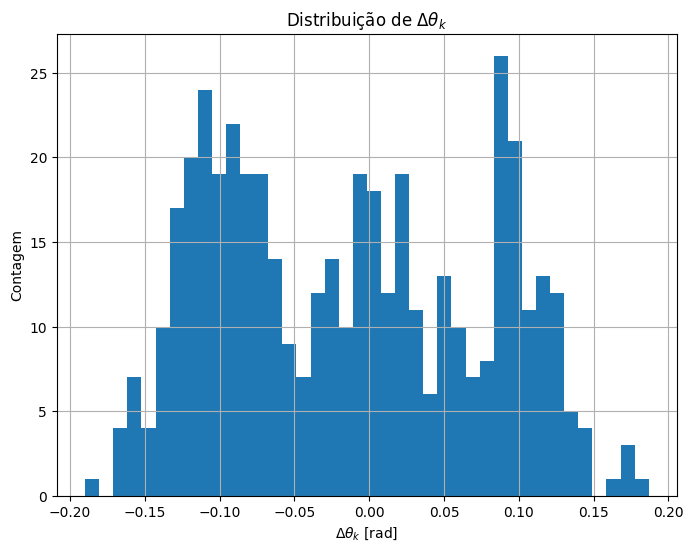

In [4]:
# Histograma de Δθ para visualização
plt.figure()
plt.hist(delta_theta, bins=40)
plt.xlabel(r"$\Delta \theta_k$ [rad]")
plt.ylabel("Contagem")
plt.title("Distribuição de $\Delta \\theta_k$")
plt.show()


## 2. Angulos do LIDAR

O LIDAR fornece 121 medições igualmente espaçadas entre -60° e +60°.  
Geramos o vector de ângulos (em radianos) correspondente a cada feixe $i$:

\begin{equation}
\alpha_i \in [-60^\circ, 60^\circ], \quad i = 0, \dots, 120
\end{equation}


In [5]:
# Ângulos LIDAR: de -60° a 60° (inclusive) com passo de 1°
angles_deg = np.linspace(-60.0, 60.0, num_beams)
angles_rad = np.deg2rad(angles_deg)

print("Primeiros 5 ângulos [deg]:", angles_deg[:5])
print("Primeiros 5 ângulos [rad]:", angles_rad[:5])


Primeiros 5 ângulos [deg]: [-60. -59. -58. -57. -56.]
Primeiros 5 ângulos [rad]: [-1.04719755 -1.02974426 -1.01229097 -0.99483767 -0.97738438]


## 3. Modelo de odometria e trajectória

Assumimos o modelo cinemático simples dado no enunciado:

\begin{align}
\theta_{k+1} &= \theta_k + \Delta \theta_k \\
x_{k+1} &= x_k + \Delta s_k \cos(\theta_k^\*) \\
y_{k+1} &= y_k + \Delta s_k \sin(\theta_k^\*)
\end{align}

onde $\theta_k^\*$ é o ângulo usado para integrar o deslocamento linear.  
Para aproximar melhor a trajectória contínua (modelo $dx/ds = \cos\theta$ e $dy/ds = \sin\theta$), usamos o **ângulo médio**:

\begin{equation}
\theta_k^\* = \theta_k + \frac{1}{2}\Delta \theta_k
\end{equation}

Isto corresponde a uma regra do ponto médio na integração em $s$, e é mais preciso do que usar apenas $\theta_k$ ou apenas $\theta_{k+1}$.


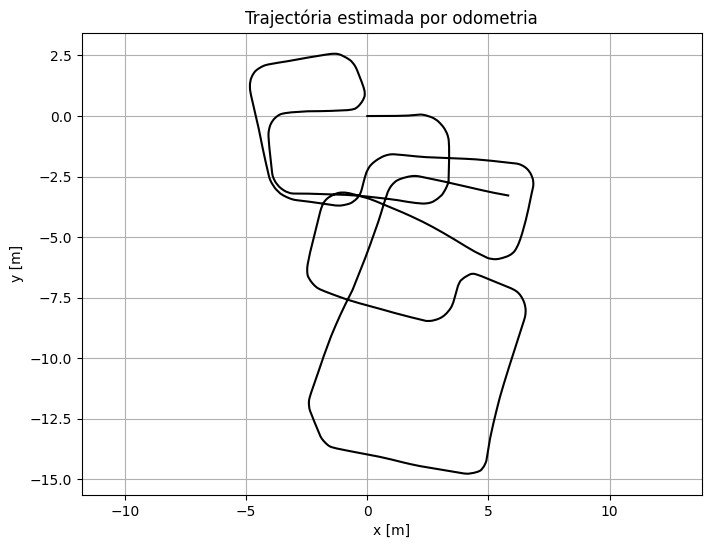

In [6]:
def compute_odometry(delta_s, delta_theta, x0=0.0, y0=0.0, theta0=0.0):
    '''
    Integra odometria incremental para obter trajectória 2D.

    Usa ângulo intermédio theta_k + Δθ_k/2 para integrar Δs_k.

    Returns
    -------
    x : np.ndarray, shape (N+1,)
        Coordenadas x da trajectória.
    y : np.ndarray, shape (N+1,)
        Coordenadas y da trajectória.
    theta : np.ndarray, shape (N+1,)
        Orientação do robô (radianos).
    '''
    N = len(delta_s)
    x = np.zeros(N + 1)
    y = np.zeros(N + 1)
    theta = np.zeros(N + 1)

    x[0], y[0], theta[0] = x0, y0, theta0

    for k in range(N):
        theta_mid = theta[k] + 0.5 * delta_theta[k]
        x[k+1] = x[k] + delta_s[k] * np.cos(theta_mid)
        y[k+1] = y[k] + delta_s[k] * np.sin(theta_mid)
        theta[k+1] = theta[k] + delta_theta[k]

    return x, y, theta


x_traj, y_traj, theta_traj = compute_odometry(delta_s, delta_theta)

plt.figure()
plt.plot(x_traj, y_traj, "-k")
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectória estimada por odometria")
plt.show()


## 4. Conversão LIDAR → coordenadas cartesianas (referencial do robô)

Para cada varrimento, convertemos as medições $(r_i, \alpha_i)$ em coordenadas cartesianas no **referencial do robô**:

\begin{align}
x^R_i &= r_i \cos \alpha_i \\
y^R_i &= r_i \sin \alpha_i
\end{align}

onde o eixo $x^R$ aponta para a frente do robô e $y^R$ para a esquerda.


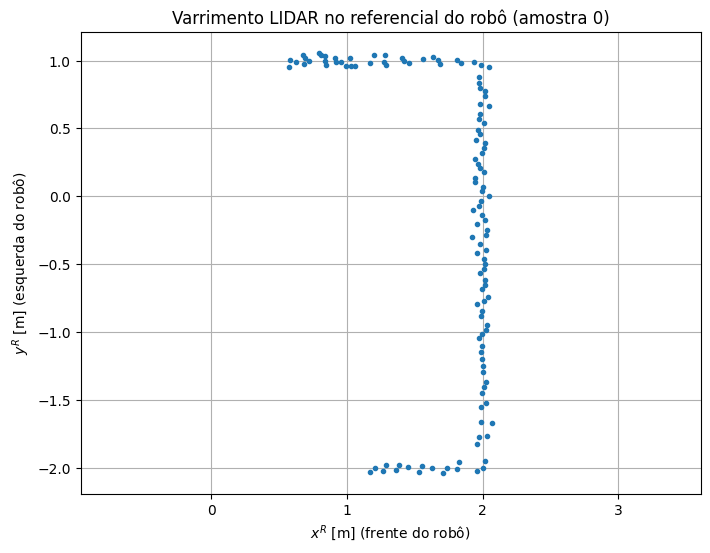

In [7]:
def scan_to_cartesian(ranges_row, angles_rad):
    '''
    Converte um varrimento LIDAR (121 raios) para coordenadas cartesianas no referencial do robô.

    Parameters
    ----------
    ranges_row : np.ndarray, shape (num_beams,)
        Raios medidos pelo LIDAR.
    angles_rad : np.ndarray, shape (num_beams,)
        Ângulos correspondentes (radianos).

    Returns
    -------
    points : np.ndarray, shape (num_beams, 2)
        Pontos (x^R, y^R) no referencial do robô.
    '''
    x_r = ranges_row * np.cos(angles_rad)
    y_r = ranges_row * np.sin(angles_rad)
    points = np.vstack((x_r, y_r)).T
    return points


# Exemplo com o primeiro varrimento
points_example = scan_to_cartesian(ranges[0], angles_rad)

plt.figure()
plt.plot(points_example[:, 0], points_example[:, 1], ".")
plt.axis("equal")
plt.xlabel(r"$x^R$ [m] (frente do robô)")
plt.ylabel(r"$y^R$ [m] (esquerda do robô)")
plt.title("Varrimento LIDAR no referencial do robô (amostra 0)")
plt.show()


## 5. Detecção de cantos (convexos e côncavos)

Usamos a geometria local de 3 pontos consecutivos $P_{i-1}$, $P_i$, $P_{i+1}$:

1. Calculamos os vectores
   \begin{align}
   \mathbf{v}_1 &= P_{i-1} - P_i \\
   \mathbf{v}_2 &= P_{i+1} - P_i
   \end{align}
2. Calculamos o ângulo entre $\mathbf{v}_1$ e $\mathbf{v}_2$:
   \begin{equation}
   \cos \phi_i = \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \, \|\mathbf{v}_2\|}
   \end{equation}
3. Se $\phi_i$ for suficientemente **agudo** (por exemplo $< 120^\circ$), consideramos que existe um canto.

Para distinguir **convexo** de **côncavo**, usamos a componente $z$ do produto vectorial 2D:  
$\mathbf{v}_1 \times \mathbf{v}_2 = v_{1x}v_{2y} - v_{1y}v_{2x}$.

- Se $(\mathbf{v}_1 \times \mathbf{v}_2)_z > 0$: definimos o canto como **convexo**;
- Se $(\mathbf{v}_1 \times \mathbf{v}_2)_z < 0$: definimos o canto como **côncavo**.

Além disso, filtramos leituras absurdas (raios muito pequenos ou muito grandes) para reduzir cantos falsos devido a ruído.


Número de cantos detectados no varrimento 0: 56


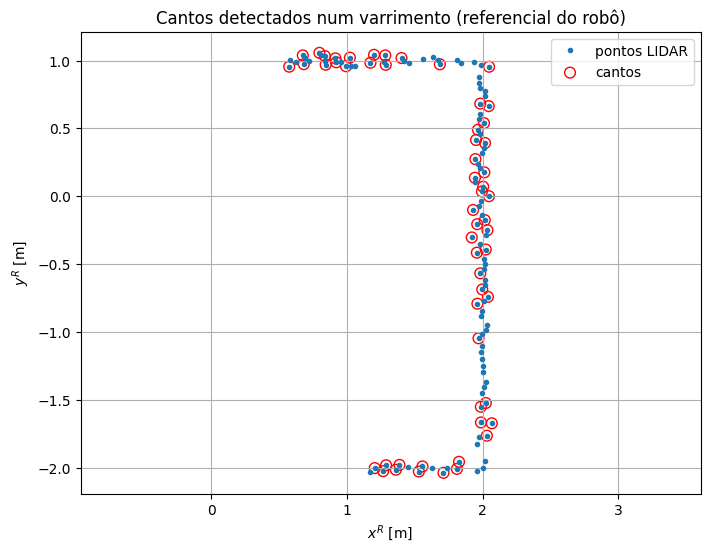

In [8]:
def detect_corners_in_scan(points_xy, r_min=0.1, r_max=10.0, angle_threshold_deg=120.0):
    '''
    Detecta cantos (convexos / côncavos) num único varrimento no referencial do robô.

    Parameters
    ----------
    points_xy : np.ndarray, shape (num_beams, 2)
        Pontos (x^R, y^R) do varrimento.
    r_min, r_max : float
        Limites mínimo e máximo de raio considerados válidos.
    angle_threshold_deg : float
        Ângulo máximo (em graus) para considerar que existe um canto (ex: 120°).

    Returns
    -------
    corner_indices : list of int
        Índices i dos pontos detectados como cantos.
    corner_types : list of str
        Tipo de canto em cada índice: "convexo" ou "concavo".
    '''
    num_points = points_xy.shape[0]
    corner_indices = []
    corner_types = []

    angle_threshold = np.deg2rad(angle_threshold_deg)

    # Cálculo dos raios para filtragem básica
    radii = np.linalg.norm(points_xy, axis=1)
    valid = (radii > r_min) & (radii < r_max)

    for i in range(1, num_points - 1):
        if not (valid[i-1] and valid[i] and valid[i+1]):
            continue

        p_prev = points_xy[i-1]
        p_curr = points_xy[i]
        p_next = points_xy[i+1]

        v1 = p_prev - p_curr
        v2 = p_next - p_curr

        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 < 1e-6 or norm_v2 < 1e-6:
            continue

        # Ângulo entre v1 e v2
        cos_phi = np.dot(v1, v2) / (norm_v1 * norm_v2)
        # Limitar para [-1, 1] para evitar problemas numéricos
        cos_phi = np.clip(cos_phi, -1.0, 1.0)
        phi = np.arccos(cos_phi)

        if phi < angle_threshold:
            # Produto vectorial 2D => componente z
            cross_z = v1[0] * v2[1] - v1[1] * v2[0]
            if cross_z > 0:
                c_type = "convexo"
            else:
                c_type = "concavo"

            corner_indices.append(i)
            corner_types.append(c_type)

    return corner_indices, corner_types


# Teste da função num varrimento
test_scan = scan_to_cartesian(ranges[0], angles_rad)
corner_idx, corner_types = detect_corners_in_scan(test_scan)

print(f"Número de cantos detectados no varrimento 0: {len(corner_idx)}")

plt.figure()
plt.plot(test_scan[:, 0], test_scan[:, 1], ".", label="pontos LIDAR")
if len(corner_idx) > 0:
    corners = test_scan[corner_idx]
    plt.scatter(corners[:, 0], corners[:, 1], s=60, facecolors="none", edgecolors="r", label="cantos")
plt.axis("equal")
plt.xlabel(r"$x^R$ [m]")
plt.ylabel(r"$y^R$ [m]")
plt.title("Cantos detectados num varrimento (referencial do robô)")
plt.legend()
plt.show()


## 6. Transformação dos cantos para o referencial do mundo

Para cada varrimento $k$ e para cada canto detectado no referencial do robô $(x^R, y^R)$,  
projectamos o ponto para o **referencial do mundo** usando a pose $(x_k, y_k, \theta_k)$ estimada por odometria:

\begin{align}
\begin{bmatrix}
x^W \\[3pt]
y^W
\end{bmatrix}
&=
\begin{bmatrix}
x_k \\[3pt]
y_k
\end{bmatrix}
+
R(\theta_k)
\begin{bmatrix}
x^R \\[3pt]
y^R
\end{bmatrix} \\[6pt]
R(\theta_k) &=
\begin{bmatrix}
\cos\theta_k & -\sin\theta_k \\
\sin\theta_k & \cos\theta_k
\end{bmatrix}
\end{align}

Assumimos que cada varrimento LIDAR $k$ está associado à pose **após** aplicar o incremento $(\Delta s_k, \Delta \theta_k)$, ou seja, à pose $(x_{k+1}, y_{k+1}, \theta_{k+1})$.


In [9]:
def transform_points_to_world(points_R, x_k, y_k, theta_k):
    '''
    Transforma pontos no referencial do robô para o referencial do mundo.

    Parameters
    ----------
    points_R : np.ndarray, shape (M, 2)
        Pontos (x^R, y^R).
    x_k, y_k : float
        Posição do robô no mundo.
    theta_k : float
        Orientação do robô (rad).

    Returns
    -------
    points_W : np.ndarray, shape (M, 2)
        Pontos (x^W, y^W).
    '''
    c = np.cos(theta_k)
    s = np.sin(theta_k)
    R = np.array([[c, -s],
                  [s,  c]])
    return points_R @ R.T + np.array([x_k, y_k])


# Loop global: detectar cantos em todos os varrimentos e transformá-los para o mundo
world_corners = []  # lista de dicts com posição no robô, no mundo, tipo, varrimento e feixe

for k in range(N):
    # Pose usada para este varrimento: após aplicar o incremento k
    x_k = x_traj[k+1]
    y_k = y_traj[k+1]
    theta_k = theta_traj[k+1]

    scan_points_R = scan_to_cartesian(ranges[k], angles_rad)
    corner_idx, corner_types = detect_corners_in_scan(scan_points_R)

    if len(corner_idx) == 0:
        continue

    corners_R = scan_points_R[corner_idx]
    corners_W = transform_points_to_world(corners_R, x_k, y_k, theta_k)

    for idx, c_type, p_R, p_W in zip(corner_idx, corner_types, corners_R, corners_W):
        world_corners.append({
            "scan_index": k,
            "beam_index": int(idx),
            "type": c_type,
            "x_R": float(p_R[0]),
            "y_R": float(p_R[1]),
            "x_W": float(p_W[0]),
            "y_W": float(p_W[1]),
        })

print(f"Número total de cantos detectados: {len(world_corners)}")


Número total de cantos detectados: 24433


In [10]:
# Converte lista de cantos para arrays para facilitar a visualização
corner_types = [c["type"] for c in world_corners]
xW = np.array([c["x_W"] for c in world_corners])
yW = np.array([c["y_W"] for c in world_corners])

is_convexo = np.array([t == "convexo" for t in corner_types])
is_concavo = np.array([t == "concavo" for t in corner_types])

print(f"Cantos convexos: {is_convexo.sum()}")
print(f"Cantos côncavos: {is_concavo.sum()}")


Cantos convexos: 12039
Cantos côncavos: 12394


## 7. Visualizações finais

### 7.1. Trajectória do robô

Primeiro representamos apenas a trajectória estimada por odometria.

### 7.2. Mapa global de cantos

Depois desenhamos:

- Trajectória do robô;
- Todos os cantos detectados no referencial do mundo,
  - Cantos **convexos** numa cor,
  - Cantos **côncavos** noutra cor.

A opacidade dos pontos pode ser reduzida para evidenciar padrões globais.


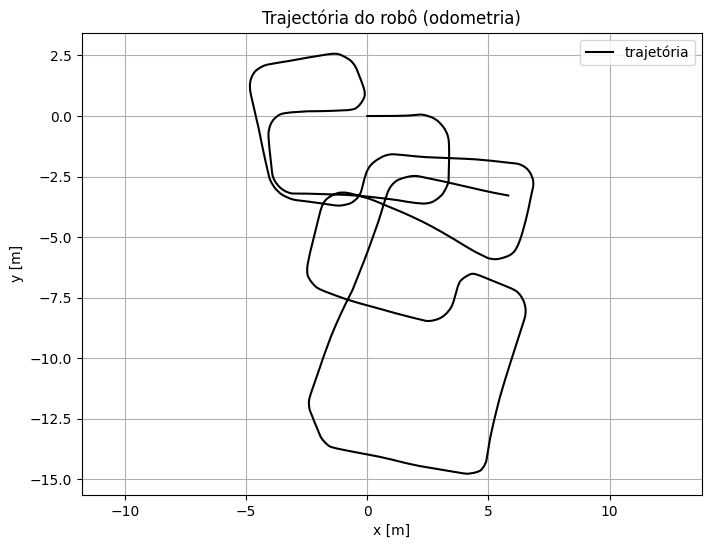

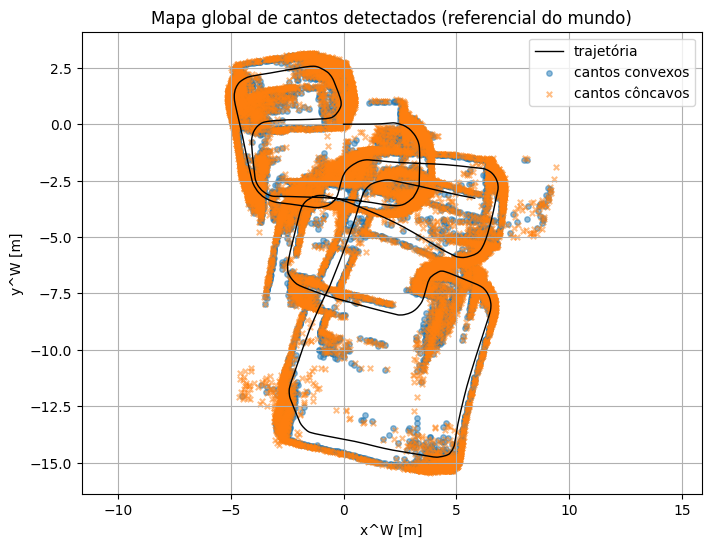

In [11]:
# 7.1 Trajectória
plt.figure()
plt.plot(x_traj, y_traj, "-k", label="trajetória")
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectória do robô (odometria)")
plt.legend()
plt.show()

# 7.2 Mapa de cantos
plt.figure()
plt.plot(x_traj, y_traj, "-k", linewidth=1.0, label="trajetória")

if is_convexo.any():
    plt.scatter(xW[is_convexo], yW[is_convexo],
                s=15, alpha=0.5, label="cantos convexos")
if is_concavo.any():
    plt.scatter(xW[is_concavo], yW[is_concavo],
                s=15, alpha=0.5, marker="x", label="cantos côncavos")

plt.axis("equal")
plt.xlabel("x^W [m]")
plt.ylabel("y^W [m]")
plt.title("Mapa global de cantos detectados (referencial do mundo)")
plt.legend()
plt.show()


## 8. Conclusões

Neste *notebook* implementámos:

- Um modelo de **odometria incremental** para estimar a trajectória do robô a partir de $(\Delta s_k, \Delta \theta_k)$;
- A conversão das leituras **LIDAR polares para cartesianas** no referencial do robô;
- Um método geométrico simples de **detecção de cantos (convexos e côncavos)** com base em 3 pontos consecutivos;
- A **transformação dos cantos** do referencial do robô para o **referencial do mundo** usando a pose estimada por odometria;
- A visualização conjunta da **trajetória** e do **mapa de cantos**, que constitui uma forma simples de SLAM baseado em marcos (landmarks).

Este código é modular, podendo ser estendido para:
- refinar os critérios de detecção de cantos;
- agrupar cantos ao longo do tempo para estimar landmarks estáveis;
- integrar um filtro de Kalman / EKF SLAM para fusão probabilística de odometria e observações.


# 9. Task 2 — EKF-SLAM online com cantos como marcos

Nesta secção implementamos um **filtro de Kalman estendido (EKF)** para estimar em tempo real:

- a pose do robô $(x, y, \theta)$
- as posições dos cantos (marcos) no mapa

A cada instante $k$:

1. Fazemos uma **previsão (prediction)** da pose com base na odometria $(\Delta s_k, \Delta \theta_k)$;
2. Detectamos cantos no varrimento LIDAR;
3. Para cada canto detectado:
   - Fazemos **data association**: verificamos se corresponde a um marco já conhecido;
   - Se for **marco conhecido**, fazemos uma **actualização (update)** do EKF;
   - Se for um **novo marco**, aumentamos o estado com as coordenadas deste novo canto.


## 9.1. Modelo de estado e ruído

### Estado

O vector de estado é:

\begin{equation}
\mathbf{x} =
\begin{bmatrix}
x \\ y \\ \theta \\
m_{1x} \\ m_{1y} \\
\vdots \\
m_{Mx} \\ m_{My}
\end{bmatrix}
\end{equation}

onde $(x,y,\theta)$ é a pose do robô e $(m_{jx}, m_{jy})$ são as coordenadas dos $M$ cantos (marcos) no **referencial do mundo**.

### Matriz de covariância

\begin{equation}
\mathbf{P} \in \mathbb{R}^{(3+2M) \times (3+2M)}
\end{equation}

representa as incertezas e correlações entre pose e marcos.

### Ruído de movimento (odometria)

Assumimos um modelo de ruído simples, gaussiano, na odometria:

- $\sigma_\text{trans}$ — desvio padrão em metros
- $\sigma_\text{rot}$ — desvio padrão em radianos

Destruidormente simples mas suficiente para este trabalho.


In [12]:
# Hiperparâmetros do EKF (podem ser ajustados)
SIGMA_TRANS = 0.05   # [m] ruído (1σ) de translação por passo
SIGMA_ROT   = 0.02   # [rad] ruído (1σ) de rotação por passo

# Ruído de medição (no referencial do robô, coordenadas x^R, y^R)
SIGMA_MEAS_XR = 0.05  # [m]
SIGMA_MEAS_YR = 0.05  # [m]

R_meas = np.diag([SIGMA_MEAS_XR**2, SIGMA_MEAS_YR**2])


## 9.2. Modelo de movimento (prediction)

Usamos o mesmo modelo de odometria que antes, agora na forma de função de transição do estado:

\begin{align}
\theta_{k+1} &= \theta_k + \Delta \theta_k \\
\theta_k^\* &= \theta_k + \tfrac{1}{2}\Delta \theta_k \\
x_{k+1} &= x_k + \Delta s_k \cos(\theta_k^\*) \\
y_{k+1} &= y_k + \Delta s_k \sin(\theta_k^\*)
\end{align}

Os marcos $m_j$ não se alteram na previsão (são estáticos).  
A matriz Jacobiana $\mathbf{F}_k = \partial f / \partial \mathbf{x}$ será uma identidade com uma sub-matriz $3\times 3$ modificada correspondente à pose.


In [13]:
def ekf_predict(x, P, delta_s_k, delta_theta_k):
    '''
    Passo de previsão (prediction) do EKF para o movimento do robô.

    x : estado actual (dimensão 3 + 2M)
    P : covariância actual
    delta_s_k, delta_theta_k : incrementos de odometria

    Returns
    -------
    x_pred, P_pred, F
    '''
    n = x.shape[0]
    # Extrair pose actual
    xr, yr, theta = x[0], x[1], x[2]

    theta_mid = theta + 0.5 * delta_theta_k
    xr_new = xr + delta_s_k * np.cos(theta_mid)
    yr_new = yr + delta_s_k * np.sin(theta_mid)
    theta_new = theta + delta_theta_k

    x_pred = x.copy()
    x_pred[0] = xr_new
    x_pred[1] = yr_new
    x_pred[2] = theta_new

    # Jacobiana F = ∂f/∂x
    F = np.eye(n)
    dxdtheta = -delta_s_k * np.sin(theta_mid)
    dydtheta =  delta_s_k * np.cos(theta_mid)
    F[0, 2] = dxdtheta
    F[1, 2] = dydtheta

    # Ruído de processo Q apenas na parte da pose
    Q_pose = np.diag([SIGMA_TRANS**2, SIGMA_TRANS**2, SIGMA_ROT**2])
    Q = np.zeros((n, n))
    Q[0:3, 0:3] = Q_pose

    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred, F


## 9.3. Modelo de medição (measurement) e data association

Para um marco $j$ com posição $(m_{jx}, m_{jy})$ no mundo, o modelo de medição exprime as suas coordenadas no **referencial do robô**:

\begin{align}
\mathbf{d} &=
\begin{bmatrix}
m_{jx} - x \\ m_{jy} - y
\end{bmatrix} \\
\begin{bmatrix}
x^R \\ y^R
\end{bmatrix}
&=
R(\theta)^\top \, \mathbf{d}
\end{align}

com

\begin{equation}
R(\theta)^\top =
\begin{bmatrix}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta
\end{bmatrix}
\end{equation}

A função de medição é então $\mathbf{z} = h(\mathbf{x}) = [x^R, y^R]^T$.  
Calculamos a Jacobiana $\mathbf{H}_j$ de $h$ relativamente à pose e ao marco $j$ para construir a matriz de observação global.

### Data association

Para cada canto observado $z^{\text{obs}}$:

1. Para cada marco existente $j$, calculamos a previsão $z_j^{\text{pred}}$ e a distância de Mahalanobis:
   \begin{equation}
   d_j^2 = (\mathbf{z}^{\text{obs}} - \mathbf{z}_j^{\text{pred}})^\top \mathbf{S}_j^{-1} (\mathbf{z}^{\text{obs}} - \mathbf{z}_j^{\text{pred}})
   \end{equation}
2. Escolhemos o marco com menor $d_j^2$;
3. Se $d_{\min}^2$ for inferior a um limiar (por exemplo baseado num valor $\chi^2$ com 2 d.o.f.), consideramos que é um **marco conhecido**;
4. Caso contrário, criamos um **novo marco** no estado.


In [14]:
def measurement_model_for_landmark(x, j):
    '''
    Calcula z_pred e Jacobiana H para o marco j.

    j : índice do marco (0, 1, 2, ...) não em termos de posição no vector,
        mas o j-ésimo marco depois da pose.
    '''
    xr, yr, theta = x[0], x[1], x[2]
    c = np.cos(theta)
    s = np.sin(theta)

    # Índices no vector de estado do marco j
    idx = 3 + 2*j
    mx = x[idx]
    my = x[idx+1]

    dx = mx - xr
    dy = my - yr

    # Medição prevista no referencial do robô
    x_r =  c*dx + s*dy
    y_r = -s*dx + c*dy
    z_pred = np.array([x_r, y_r])

    # Jacobiana H em relação ao estado completo
    n = x.shape[0]
    H = np.zeros((2, n))

    # Derivadas em relação a x, y, theta, mx, my
    # z_xr =  c*dx + s*dy
    # z_yr = -s*dx + c*dy

    # ∂z_xr/∂x = -c, ∂z_xr/∂y = -s, ∂z_xr/∂theta = -s*dx + c*dy
    H[0, 0] = -c
    H[0, 1] = -s
    H[0, 2] = -s*dx + c*dy
    # ∂z_xr/∂mx = c, ∂z_xr/∂my = s
    H[0, idx]   = c
    H[0, idx+1] = s

    # ∂z_yr/∂x =  s, ∂z_yr/∂y = -c, ∂z_yr/∂theta = -c*dx - s*dy
    H[1, 0] =  s
    H[1, 1] = -c
    H[1, 2] = -c*dx - s*dy
    # ∂z_yr/∂mx = -s, ∂z_yr/∂my = c
    H[1, idx]   = -s
    H[1, idx+1] =  c

    return z_pred, H


In [15]:
def ekf_update_for_measurement(x, P, z_obs, landmark_index):
    '''
    Atualização EKF para uma medição de um marco já existente.

    landmark_index : índice j do marco (0-based, em termos de "marco j")
    '''
    z_pred, H = measurement_model_for_landmark(x, landmark_index)
    y = z_obs - z_pred  # inovação

    S = H @ P @ H.T + R_meas
    K = P @ H.T @ np.linalg.inv(S)

    x_upd = x + K @ y
    P_upd = (np.eye(P.shape[0]) - K @ H) @ P
    return x_upd, P_upd


In [16]:
def ekf_add_new_landmark(x, P, z_obs):
    '''
    Cria um novo marco no estado a partir de uma medição z_obs = [x^R, y^R]
    assumindo que a pose do robô está dada por x[0:3].
    '''
    xr, yr, theta = x[0], x[1], x[2]
    c = np.cos(theta)
    s = np.sin(theta)

    x_r, y_r = z_obs[0], z_obs[1]

    # Converter ponto no robô (x^R, y^R) para mundo (x^W, y^W)
    # [x^W, y^W]^T = [x, y]^T + R(theta) * [x^R, y^R]^T
    mx = xr + c*x_r - s*y_r
    my = yr + s*x_r + c*y_r

    # Aumentar o vector de estado
    x_new = np.concatenate([x, np.array([mx, my])])

    # Aumentar a covariância
    n_old = P.shape[0]
    P_new = np.zeros((n_old+2, n_old+2))
    P_new[:n_old, :n_old] = P

    # Incerteza inicial do marco relativamente alta
    sigma_m = 0.5  # [m]
    P_new[n_old:, n_old:] = np.diag([sigma_m**2, sigma_m**2])

    return x_new, P_new


## 9.4. Laço principal do EKF-SLAM

Agora juntamos tudo:

- Inicializamos o estado com apenas a pose $(0,0,0)$ e sem marcos;
- Percorremos todas as amostras $k = 0, \dots, N-1$;
- Em cada passo:
  1. `ekf_predict` com a odometria $(\Delta s_k, \Delta \theta_k)$;
  2. Convertemos o varrimento LIDAR para o referencial do robô;
  3. Detectamos cantos com `detect_corners_in_scan`;
  4. Para cada canto detectado:
     - Fazemos data association com base na distância de Mahalanobis;
     - Actualizamos o estado ou adicionamos um novo marco.


In [24]:
# Limiar para a distância de Mahalanobis (2 d.o.f.)
# Valores de referência: chi2(0.99, 2) ≈ 9.21, chi2(0.95, 2) ≈ 5.99
MAHALANOBIS_THRESHOLD = 9.21

# Limites para manter o runtime controlado
MAX_CORNERS_PER_SCAN = 8     # máximo de cantos processados por varrimento
MAX_LANDMARKS = 200          # máximo de marcos no estado EKF

# Estado inicial: apenas pose
x_ekf = np.array([0.0, 0.0, 0.0])
P_ekf = np.diag([1e-6, 1e-6, 1e-6])  # praticamente certeza absoluta no início

# Para armazenamento da trajectória estimada pelo EKF
ekf_poses = []  # lista de (x, y, theta)
num_landmarks_over_time = []

for k in range(N):

    # Print de progresso para perceber se está a avançar
    if k % 25 == 0:
        print(f"k={k}/{N} | marcos={(x_ekf.shape[0]-3)//2}")

    # 1) Prediction
    x_ekf, P_ekf, F_k = ekf_predict(x_ekf, P_ekf, delta_s[k], delta_theta[k])

    # Guardar pose após previsão (antes de medições)
    ekf_poses.append(x_ekf[0:3].copy())
    num_landmarks_over_time.append((x_ekf.shape[0] - 3) // 2)

    # 2) Processar varrimento e detectar cantos
    scan_points_R = scan_to_cartesian(ranges[k], angles_rad)
    corner_idx, corner_types_k = detect_corners_in_scan(scan_points_R)

    if len(corner_idx) == 0:
        continue

    # Limitar o número de cantos por varrimento (evita explosão de custo)
    corner_idx = corner_idx[:MAX_CORNERS_PER_SCAN]

    for idx in corner_idx:
        z_obs = scan_points_R[idx]  # [x^R, y^R]

        # Data association: procurar marco mais provável
        num_landmarks = (x_ekf.shape[0] - 3) // 2

        if num_landmarks == 0:
            # Primeiro marco: adicionar directamente
            x_ekf, P_ekf = ekf_add_new_landmark(x_ekf, P_ekf, z_obs)
            continue

        best_j = None
        best_d2 = np.inf  # queremos minimizar

        for j in range(num_landmarks):
            z_pred, H = measurement_model_for_landmark(x_ekf, j)
            y = z_obs - z_pred
            S = H @ P_ekf @ H.T + R_meas

            # Gate rápido (evita gastar tempo com candidatos obviamente longe)
            if np.linalg.norm(y) > 1.0:
                continue

            try:
                # Distância de Mahalanobis sem inv(S)
                d2 = float(y.T @ np.linalg.solve(S, y))
            except np.linalg.LinAlgError:
                continue

            if d2 < best_d2:
                best_d2 = d2
                best_j = j

        # Verificar se melhor correspondência é suficientemente boa
        if best_j is not None and best_d2 < MAHALANOBIS_THRESHOLD:
            # Marco conhecido -> update EKF
            x_ekf, P_ekf = ekf_update_for_measurement(x_ekf, P_ekf, z_obs, best_j)
        else:
            # Novo marco -> adicionar, mas com limite máximo
            num_landmarks = (x_ekf.shape[0] - 3) // 2
            if num_landmarks < MAX_LANDMARKS:
                x_ekf, P_ekf = ekf_add_new_landmark(x_ekf, P_ekf, z_obs)
            else:
                # Se já temos marcos a mais, ignoramos novos para não rebentar o estado
                continue

# Converter trajectória EKF para arrays
ekf_poses = np.array(ekf_poses)  # shape (N, 3)
num_landmarks_over_time = np.array(num_landmarks_over_time)

print("Dimensão final do estado EKF:", x_ekf.shape[0])
print("Número final de marcos:", (x_ekf.shape[0] - 3) // 2)


k=0/452 | marcos=0
k=25/452 | marcos=16
k=50/452 | marcos=40
k=75/452 | marcos=56
k=100/452 | marcos=60
k=125/452 | marcos=64
k=150/452 | marcos=71
k=175/452 | marcos=99
k=200/452 | marcos=121
k=225/452 | marcos=136
k=250/452 | marcos=154
k=275/452 | marcos=165
k=300/452 | marcos=186
k=325/452 | marcos=200
k=350/452 | marcos=200
k=375/452 | marcos=200
k=400/452 | marcos=200
k=425/452 | marcos=200
k=450/452 | marcos=200
Dimensão final do estado EKF: 403
Número final de marcos: 200


## 9.5. Resultados do EKF-SLAM

Vamos comparar a trajectória baseada apenas em odometria com a trajectória estimada pelo EKF-SLAM, e visualizar a posição final dos marcos (cantos) no mapa.


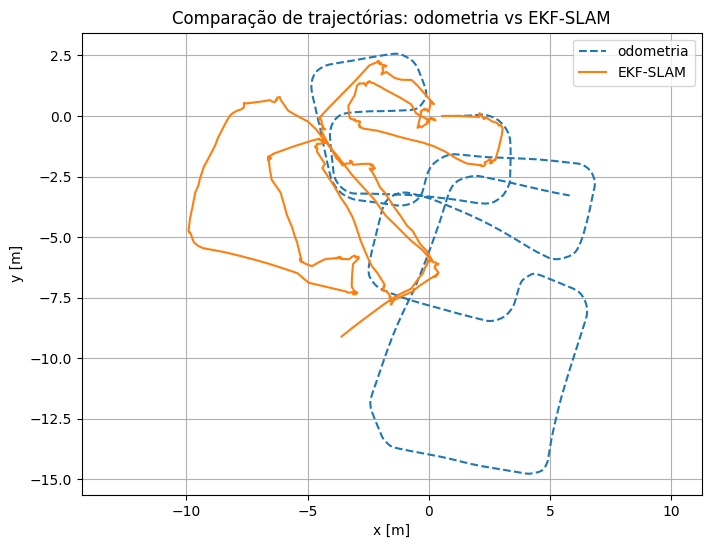

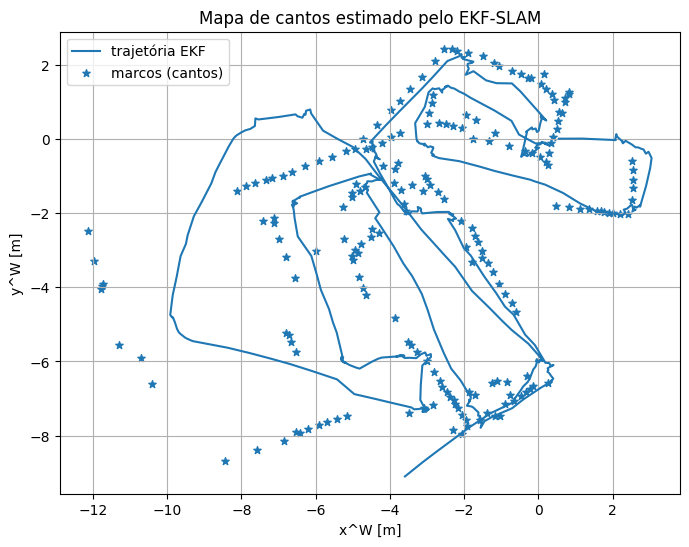

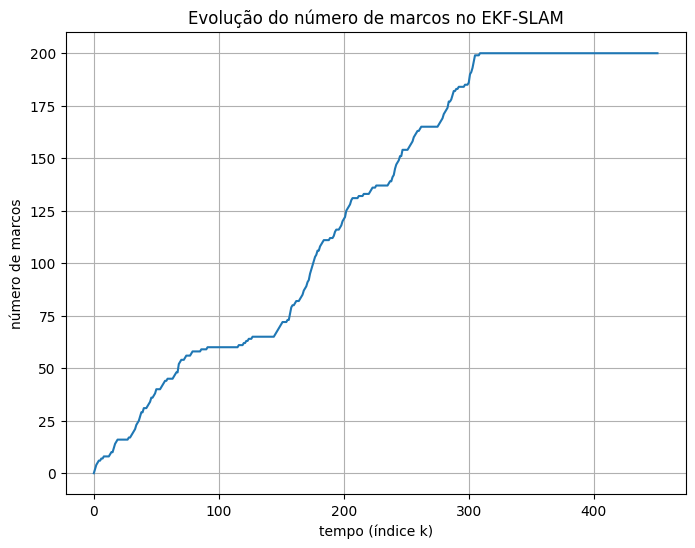

In [25]:
# Trajectória por odometria (já tínhamos x_traj, y_traj)
x_odo = x_traj[1:1+N]
y_odo = y_traj[1:1+N]

# Trajectória EKF (x, y)
x_ekf_traj = ekf_poses[:, 0]
y_ekf_traj = ekf_poses[:, 1]

plt.figure()
plt.plot(x_odo, y_odo, "--", label="odometria")
plt.plot(x_ekf_traj, y_ekf_traj, "-", label="EKF-SLAM")
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Comparação de trajectórias: odometria vs EKF-SLAM")
plt.legend()
plt.show()

# Mapa de marcos estimados pelo EKF
num_landmarks_final = (x_ekf.shape[0] - 3) // 2
mx_list = []
my_list = []
for j in range(num_landmarks_final):
    idx = 3 + 2*j
    mx_list.append(x_ekf[idx])
    my_list.append(x_ekf[idx+1])
mx_list = np.array(mx_list)
my_list = np.array(my_list)

plt.figure()
plt.plot(x_ekf_traj, y_ekf_traj, "-", label="trajetória EKF")
plt.scatter(mx_list, my_list, marker="*", s=30, label="marcos (cantos)")
plt.axis("equal")
plt.xlabel("x^W [m]")
plt.ylabel("y^W [m]")
plt.title("Mapa de cantos estimado pelo EKF-SLAM")
plt.legend()
plt.show()

# Evolução do número de marcos
plt.figure()
plt.plot(num_landmarks_over_time)
plt.xlabel("tempo (índice k)")
plt.ylabel("número de marcos")
plt.title("Evolução do número de marcos no EKF-SLAM")
plt.grid(True)
plt.show()


# 10. Task 3 — Evolução da pose e do mapa, e noção de smoothing

A Task 3 pede:

> *"Based on all the measurements, estimate the evolution of the pose of the robot and of the map of the environment.  
> Suggestion: Look for information about smoothing in the literature."*

Neste *notebook* já temos:

- A **evolução da pose** ao longo do tempo, estimada pelo EKF-SLAM (`ekf_poses`);
- O **mapa dos cantos** (marcos) estimado a partir de todas as medições disponíveis até cada instante;
- A forma clássica de **filtro** (filtering): em cada instante usamos apenas as medições até esse instante.

Nesta secção:

1. Visualizamos explicitamente a evolução da pose e do mapa ao longo do tempo;
2. Discutimos a noção de **smoothing** em SLAM e como se poderia estender este trabalho para implementar um *smoother* (por exemplo, RTS smoother ou Graph-SLAM).


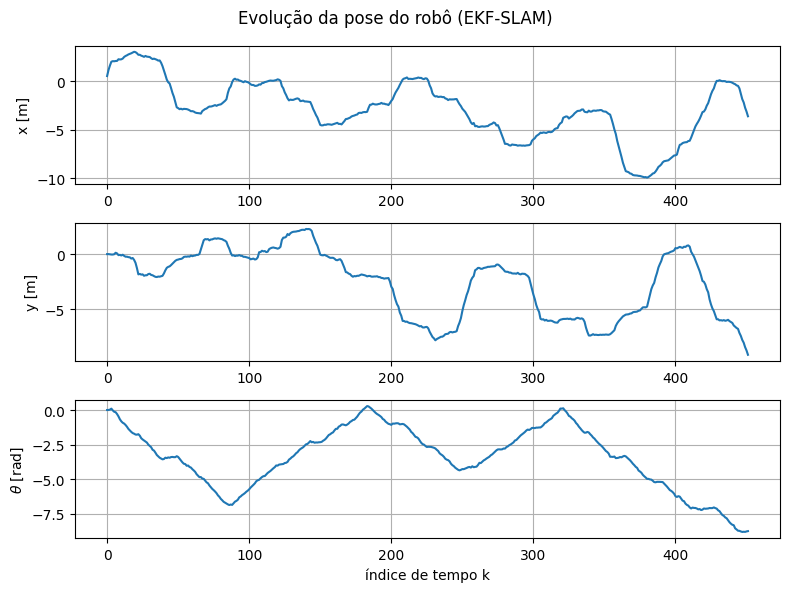

In [26]:
# Evolução da pose (x, y, theta) ao longo do tempo
t = np.arange(N)

plt.figure()
plt.subplot(3,1,1)
plt.plot(t, ekf_poses[:,0])
plt.ylabel("x [m]")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, ekf_poses[:,1])
plt.ylabel("y [m]")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, ekf_poses[:,2])
plt.ylabel(r"$\theta$ [rad]")
plt.xlabel("índice de tempo k")
plt.grid(True)

plt.suptitle("Evolução da pose do robô (EKF-SLAM)")
plt.tight_layout()
plt.show()


## 10.1. Smoothing vs Filtering

No EKF-SLAM que implementámos até agora fazemos **filtering**:

- A estimativa em $k$ usa apenas medições até $k$;
- Quando surgem medições futuras $(k' > k)$, **não** corrigimos retroactivamente as estimativas passadas.

Em **smoothing**, em vez de estimar apenas $\mathbf{x}_k$ dado o passado, estimamos **toda a trajectória** e mapa:

\begin{equation}
p(\mathbf{x}_{0:T}, \mathcal{M} \mid \mathcal{Z}_{0:T}, \mathcal{U}_{0:T})
\end{equation}

usando **todas** as medições $\mathcal{Z}_{0:T}$ e comandos/odometria $\mathcal{U}_{0:T}$.

### Exemplos de técnicas de smoothing

- **Rauch–Tung–Striebel (RTS) smoother**:  
  - Faz-se uma passada forward com EKF (guardar $x_k^{\text{pred}}, x_k^{\text{filt}}, P_k^{\text{pred}}, P_k^{\text{filt}}, F_k$);  
  - Depois uma passada backward com as equações de smoothing:
    \begin{align}
    \mathbf{C}_k &= \mathbf{P}_k^{\text{filt}} F_k^\top \left(\mathbf{P}_{k+1}^{\text{pred}}\right)^{-1} \\
    \mathbf{x}_k^{\text{smooth}} &= \mathbf{x}_k^{\text{filt}} + \mathbf{C}_k \left(\mathbf{x}_{k+1}^{\text{smooth}} - \mathbf{x}_{k+1}^{\text{pred}}\right)
    \end{align}
- **Graph-SLAM / bundle adjustment**:  
  - Modela-se toda a trajectória e mapa como um problema de **optimização não linear** (grafo de factores);  
  - Minimiza-se a soma dos erros de todas as medições (odometria + observações LIDAR) sobre todas as poses e marcos.

### Extensão possível (trabalho futuro)

Para manter o código claro e dentro do contexto da UC, não implementamos aqui um smoother completo, mas seria possível:

1. Guardar, na fase de EKF-SLAM forward, as matrizes $F_k$, $P_k^{\text{pred}}$, $P_k^{\text{filt}}$ e os estados filtrados;
2. Implementar um **RTS smoother** para obter uma trajectória suavizada $(x_k^{\text{smooth}}, y_k^{\text{smooth}}, \theta_k^{\text{smooth}})$;
3. Comparar graficamente trajectória por odometria, por EKF filtrado e por EKF suavizado.

Esta discussão mostra a diferença entre *filtering* (o que implementámos) e *smoothing* (extensão natural discutida na literatura de SLAM).
